In [1]:
import astropy
from astropy.io import fits 
from astropy.time import Time
from astropy.visualization import time_support
from astropy.timeseries import LombScargle
from astropy.convolution import Box1DKernel
from astropy.convolution import convolve
import matplotlib.pyplot as plt
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import numpy as np
import numpy.ma as ma
import os
import pandas as pd
import scipy.signal as sig
from astropy.stats import sigma_clip
import warnings
import time 
import itertools


In [2]:
from functools import partial

import matplotlib as mpl
from scipy import signal, stats
from scipy.ndimage import center_of_mass

# install moonbow first. in repo root:
# pip install -e . --no-deps
from moonbow.fit import Fit

rng = np.random.default_rng()

In [3]:
def dataClean(filename): 
    
    """ This function removes nan values and corrects time values for TESS 20 second cadence data. 
        Also corrects TESS flux to energy in ergs."""
    
    #Create an array of time and flux data with nans removed    
    with fits.open(filename, mode="readonly",ignore_missing_simple=True) as hdulist:
        raw_time = hdulist[1].data['TIME']
        raw_flux = hdulist[1].data['PDCSAP_FLUX']
        raw_err = hdulist[1].data['PDCSAP_FLUX_ERR']
        ontime = hdulist[1].header['LIVETIME']
        ra = hdulist[0].header['RA_OBJ']
        dec = hdulist[0].header['DEC_OBJ']
    data = np.vstack((raw_time, raw_flux, raw_err))
    nonan_data = data[:, ~np.isnan(data).any(axis=0)]

    times = nonan_data[0]
    flux = nonan_data[1]
    error = nonan_data[2]
    
    #Create Dataframe of cleaned data
    time = np.array(times)
    flux = np.array(flux)
    err = np.array(error)
   
    skypos = (ra,dec)

    #Convert energy to ergs
    #dist_cm = distance_pc * 3.086e+18
    #ergs = []
    #ergs_err = []
    
    #for i in flux: 
    #    fluence = i * eff_width
    #    energy = (4 * np.pi * (dist_cm**2) * fluence)
    #    ergs.append(energy*1.95829e-9) #AB system zero point
        
    #for i in err:
    #    fluence_err = i*eff_width
    #    energy_err = (4 * np.pi * (dist_cm**2) * fluence_err)
    #    ergs_err.append(energy_err*1.95829e-9) #AB system zero point
        
    #energy = np.asarray(ergs)
    #error = np.asarray(ergs_err)

    
    #Return cleaned data
    return pd.DataFrame({
                        'Time': time,
                        #'Energy': energy,
                        #'Energy Error': error,
                        'Flux': flux,
                        'Flux Error': err
    }),ontime,skypos

In [4]:
#Using only until large flare function is completed, need more stars to get a better idea for a good
#model for stellar quiescence generation

def generate_Qcurve(clean_dataframe):
    """ This function takes cleaned data to create a dataframe of the estimated quiescent light curve"""

    q_time = clean_dataframe['Time'] # time associated w/ quiescent flux
    
    #Set and index variables
    fluxes = clean_dataframe['Flux']
    times = clean_dataframe['Time']
    F_err = clean_dataframe['Flux Error'] 

    #Smooth
    smooth_1 = sig.savgol_filter(fluxes,1400,3)
    q_flux = sig.savgol_filter(smooth_1,2000,3)
    
    #Create/return dataframe
    
    return pd.DataFrame({
                'Time': q_time,
                'Quiescent Flux':q_flux
    })


In [5]:
def find_ix_ranges(ix, buffer=False):
    """ Finds indexes in the range.
    
        From MC GALEX function defs"""
    
    foo, bar = [], []
    for n, i in enumerate(ix):
        if len(bar) == 0 or bar[-1] == i-1:
            bar += [i]
        else:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
            bar = [i]
        if n == len(ix)-1:
            if buffer:
                bar.append(min(bar)-1)
                bar.append(max(bar)+1)
            foo += [np.sort(bar).tolist()]
    return foo

In [6]:
def get_inff(lc, clipsigma=3, quiet=True, band='NUV',
             binsize=20.):
    """ Calculates the Instantaneous Non-Flare Flux values.
    
        From MC GALEX function defs"""
    
    sclip = sigma_clip(np.array(lc['Flux']), sigma=clipsigma)
    inff = np.ma.median(sclip)
    inff_err = np.sqrt(inff*len(sclip)*binsize)/(len(sclip)*binsize)
    if inff and not quiet:
        print('Quiescent at {m} AB mag.'.format(m=gt.counts2mag(inff, band)))
    return inff, inff_err

In [7]:
def find_flare_ranges(curve,q_curve,sig,quiescence=None):
    """This function will run through the data to find 
    flares and ranges of flares. This function will return
    a table of flares ranges. 
    
    Adapted from MC GALEX function defs.
    Stage: complete"""
    
    tranges = [[min(curve['Time']), max(curve['Time'])]] 
    if not quiescence:
        q, q_err = get_inff(curve)
    else:
        q, q_err = quiescence
    flare_ranges = []
    for trange in tranges:
        ix = np.where(((np.array(curve['Flux'].values)-(sig*np.array(curve['Flux Error'].values)) >= q_curve['Quiescent Flux'])))[0]
        flareFlux = ix
        if not len(ix):
            continue
        flux_ix = []
        
        for ix_range in find_ix_ranges(ix):
            # go backwards
            consec = 0 
            err = curve.iloc[ix_range[0]]['Flux Error'] 
            
            #while flux - err > quiescence, find 2 consecutive points within quiescent curve
            while (curve.iloc[ix_range[0]]['Flux']-err >= q_curve.iloc[ix_range[0]]['Quiescent Flux']) and ix_range[0] > 0 or (consec < 1 and ix_range[0] >0):
                err = curve.iloc[ix_range[0]]['Flux Error']

                if curve.iloc[ix_range[0]]['Flux']- err < q_curve.iloc[ix_range[0]]['Quiescent Flux']:
                    consec +=1
                else: 
                    consec = 0
                if (curve.iloc[ix_range[0]+1]['Time']-curve.iloc[ix_range[0]]['Time']) > 1000: 
                    break               
                ix_range = [ix_range[0] - 1] + ix_range
                
                # go forwards
            consec = 0 
            err = curve.iloc[ix_range[-1]]['Flux Error']
            while(curve.iloc[ix_range[-1]]['Flux'] - err >= q_curve.iloc[ix_range[-1]]['Quiescent Flux']) and ix_range[-1] != len(curve)-1 or (consec <1 and ix_range[:-1]!= len(curve)-1):
                err = curve.iloc[ix_range[-1]]['Flux Error']
                if curve.iloc[ix_range[-1]]['Flux']-err < q_curve.iloc[ix_range[-1]]['Quiescent Flux']:
                    consec += 1
                else: 
                    consec = 0
                if curve.iloc[ix_range[0]]['Time']-curve.iloc[ix_range[-1]]['Time'] > 1000: 
                    break
                ix_range = ix_range + [ix_range[-1] + 1]
                
            flux_ix += ix_range
        ix = np.unique(flux_ix)
        flare_ranges += find_ix_ranges(list(np.array(ix).flatten()))
    return(flare_ranges,flareFlux)


In [8]:
def refine_flare_ranges(curve,q_curve, sig=3., flare_ranges=None):
    """ Identify the start and stop indexes of a flare event after
    refining the INFF by masking out the initial flare detection indexes. 
    From MC GALEX function defs."""
    time_support()
    if not flare_ranges:
        flare_ranges, _ = find_flare_ranges(curve, q_curve, sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    quiescience_mask = [False if i in flare_ix else True for i in
                        np.arange(len(curve['Time']))]
    quiescence = q_curve
    quiescence_err = (np.sqrt(curve['Flux'][quiescience_mask].sum())/curve['Flux'].sum())
    flare_ranges, flare_3sigs = find_flare_ranges(curve,q_curve,
                                                  quiescence=(quiescence,
                                                              quiescence_err),
                                                  sig=sig)
    flare_ix = list(itertools.chain.from_iterable(flare_ranges))
    not_flare_ix = list(set([x for x in range(len(curve['Time']))]) - set(flare_ix))
      
    return flare_ranges, flare_ix

In [9]:
def qpp_find(flaring_frame,ranges_ix,energy_ix):
    
    ranges = []
    for i,v in enumerate(ranges_ix):
        t = flaring_frame['Time'][v]
        f = flaring_frame['Flux'][v]
        ranges.append([i,t,f])

        #Select Large Flares

    large_flares = []
    for i,v in enumerate(ranges_ix):
        if len(v)>=45:                    #~15 minute minimum                    
            large_flares.append((v))
        else:
            continue

#Match Data to Large Flares

    large_flare_data = []
    for i,v in enumerate(large_flares):
        data = flaring_frame['Energy'][large_flares[i]]
        large_flare_data.append(data)
    
    norm_flares=[] #normalize flare values
    for i in range(len(large_flare_data)):
        mx = max(large_flare_data[i])
        norm_flares.append(large_flare_data[i]/mx)
    
    times=[]
    for i in range(len(large_flares)):
        t = flaring_frame['Time'][large_flare_data[i].index]
        times.append(t)
        
    lg_flare_data=[]
    lg_flare_time=[]
    lg_flare_det=[]
    lg_flare_params = []
    flare_fits = []

    for i in range(len(large_flares)):
        model = aflare2
        x = flaring_frame['Time'][large_flares[i]]
        y = norm_flares[i]
        data = pd.DataFrame({'time': x, 'energy': y})
    
        rise = x[0:np.argmax(y)].values
        fwhm = (max(rise)-min(rise))*2
    
        fitter = Fit(
        underlying_function=model,
        dimensionality=1,
        data=data,
        dependent_variable='energy')
    
        fitter.make_vector(independent_variables=['time'])
        fitter.fit(guess=np.array((max(rise),fwhm,1,
                              1.00000, 1.94053, -0.175084, -2.3769, -1.12498,
                              0.689008, -1.600536, 0.302963, -0.278318))) 
        if fitter.det > 0.70:
            lg_flare_time.append(x)
            lg_flare_data.append(y)
            lg_flare_det.append(fitter.det)
            fit_params, covariance_matrix = fitter.curve_fit
            lg_flare_params.append((fit_params))
            fit = fitter.fitted_curve 
            flare_fits.append((fit))
    return lg_flare_data, lg_flare_time, lg_flare_det, lg_flare_params, flare_fits

In [10]:
def fit_residuals(lg_flare_data,flare_fits):
    residuals = []
    for i in range(len(lg_flare_data)):
        res_i = lg_flare_data[i]-flare_fits[i]
        residuals.append((res_i))

    kernel = Box1DKernel(8)
    res_fits = []
    for i in range(len(residuals)):
        res_fit = sig.savgol_filter(residuals[i],21,3)
        fit2 = convolve(res_fit,kernel,boundary='extend')
        res_fits.append(fit2)
    
    return(residuals, res_fits)


#to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(res_fits)):
#    ax.flat[i].plot(range(len(residuals[i])),residuals[i],c='grey')
#    ax.flat[i].plot(range(len(res_fits[i])),res_fits[i],c='black')

In [11]:
def energyCalculation2(flaring_frame,q_frame,flare_ranges,dist_pc,binsize=20):
    """This function will calculate the energies of each flare.
        Stage: complete"""

    distance_cm = dist_pc*3.086e+18
    eff_width = 3.898e-5 
    flare_flux = flaring_frame['Flux'][flare_ranges[1]]-q_frame['Quiescent Flux'][flare_ranges[1]]
    flare_flux_error = flaring_frame['Flux Error'][flare_ranges[1]]
    
    
    energy_error=[]
    energies=[]
    flare_flux[flare_flux<0]=0
    
    for i,v in enumerate(flare_ranges[0]):
        integrated_flux = (flare_flux[v]*binsize).sum()
        fluence_error = np.sqrt(((flare_flux_error[v]*binsize)**2).sum())*eff_width
        fluence = integrated_flux*eff_width
        energy = (4 * np.pi * (distance_cm**2) * fluence)
        energy_err = (4 * np.pi * (distance_cm**2) * fluence_error)
        energy_error.append(energy_err*1.95829e-9 )
        energies.append(energy*1.95829e-9) 
        
    #Using AB system zero point (1.95829e-9 erg/cm2/s/A) from 
    #http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?id=TESS/TESS.Red&&mode=browse&gname=TESS&gname2=TESS
    
    return(energies,energy_error)

In [12]:
def FlareTable(flaring_frame,flare_ranges):#,energies):
    """This function will build a table of all flares.
        Stage: complete"""
    #Define variables
    times = flaring_frame['Time']
    energy = energies[0]
    energy_error = energies[1]
    
    #find peaks
    peak_energy = np.argmax(energy)
    peak_time = times(np.where(np.argmax(energy)))
    duration = []
    
    for flare in flare_ranges[0]:
        start_ix = times[flare[0]]
        stop_ix = times[flare[-1]]
        duration.append(((times[flare[-1]]-times[flare[0]])).sec)
    
    #Build flare table
    flareTable = pd.DataFrame({
                                "Peak Time": peak_time,
                                "Peak Energy": peak_energy,
                                "Duration (s)": duration,
                                "Total Energy": energy,
                                "Energy Error": energy_error
    })
    
    return(flareTable)
        

In [13]:
def aflare2(t, tpeak, fwhm, ampl,
            c0,c1,c2,c3,c4,
            d0,d1,d2,d3):
#    t : 1-d array
#        The time array to evaluate the flare over
#    tpeak : float
#        The time of the flare peak
#    fwhm : float
#        The "Full Width at Half Maximum", timescale of the flare
#   ampl : float
#        The amplitude of the flare
#    Returns
#    flare : 1-d array
#        The flux of the flare model evaluated at each time
    #_fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    _fr = [c0,c1,c2,c3,c4]
    #_fd = [0.689008, -1.60053, 0.302963, -0.278318]
    _fd = [d0,d1,d2,d3]
    
    t = np.array(t)
    flare = np.piecewise(t, [(t<= tpeak) * (t-tpeak)/fwhm > -1.,
                                (t > tpeak)],
                            [lambda x: (_fr[0]+                       # 0th order
                                        _fr[1]*((x-tpeak)/fwhm)+      # 1st order
                                        _fr[2]*((x-tpeak)/fwhm)**2.+  # 2nd order
                                        _fr[3]*((x-tpeak)/fwhm)**3.+  # 3rd order
                                        _fr[4]*((x-tpeak)/fwhm)**4. ),# 4th order
                             lambda x: (_fd[0]*np.exp( ((x-tpeak)/fwhm)*_fd[1] ) +
                                        _fd[2]*np.exp( ((x-tpeak)/fwhm)*_fd[3] ))]
                            ) * np.abs(ampl) # amplitude

    return flare

### Af Psc Analysis

In [14]:
#rawdata = '/Users/katborski/Documents/GitHub/AFPSC/TESS/tess2021232031932-s0042-0000000250081915-0213-a_fast-lc.fits'
#flaring_frame = dataClean(rawdata,35,3.898e-5) #35=dist in pc, 3.898e-5=eff width for Af Psc
#q_frame = generate_Qcurve(flaring_frame)

In [15]:
#ranges_ix,energy_ix = find_flare_ranges(flaring_frame, q_frame, 3,35, quiescence=None)

In [16]:
#qpps = qpp_find(flaring_frame, ranges_ix, energy_ix)

In [17]:
#res_fit = fit_residuals(qpps[0],qpps[4])

In [18]:
###to view/plot davenport fit: 

#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(lg_flare_data)):    
#    ax.flat[i].plot(lg_flare_time[i],lg_flare_data[i])
#    ax.flat[i].plot(lg_flare_time[i],fits_[i],c='black')
#    ax.flat[i].set_title(lg_flare_det[i])
#    plt.setp(ax, xticks=[]) 

In [19]:
###to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(lg_flare_data)))
#for i in range(len(res_fits)):
#    ax.flat[i].plot(range(len(residuals[i])),residuals[i],c='grey')
#    ax.flat[i].plot(range(len(res_fits[i])),res_fits[i],c='black')

### Test Analysis w/ EV Lac

In [20]:
#test_rawdata = '/Users/katborski/Documents/GitHub/QPPs/moonbow-main/tess2022244194134-s0056-0000000154101678-0243-a_fast-lc.fits'
#test_flaring_frame = dataClean(test_rawdata,5.05,3.898e-5) #5.05=dist in pc to EV Lac, 3.898e-5=eff width for TESS
#test_q_frame = generate_Qcurve(test_flaring_frame)


In [21]:
#test_ranges_ix,test_energy_ix = find_flare_ranges(test_flaring_frame,test_q_frame,4,5.05,quiescence=None)

In [22]:
#test_qpps = qpp_find(test_flaring_frame, test_ranges_ix, test_energy_ix)

In [23]:
#test_res_fit = fit_residuals(test_qpps[0],test_qpps[4])

In [24]:
###to view/plot davenport fit: 

#fig,ax = plt.subplots((len(test_qpps[0])))
#for i in range(len(test_qpps[0])):    
#    ax.flat[i].plot(test_qpps[1][i],test_qpps[0][i])
#    ax.flat[i].plot(test_qpps[1][i],test_qpps[4][i],c='black')
#    ax.flat[i].set_title(test_qpps[2][i])
#    plt.setp(ax, xticks=[]) 
#plt.show()

In [25]:
###to view/plot residual fits: 
    
#fig,ax = plt.subplots((len(test_res_fit[0])))
#for i in range(len(test_res_fit[0])):
#    ax.flat[i].plot(range(len(test_res_fit[0][i])),test_res_fit[0][i],c='grey')
#    ax.flat[i].plot(range(len(test_res_fit[1][i])),test_res_fit[1][i],c='black')
#plt.show()

In [26]:
#ALL WORKING, uncomment singular '#' lines to run.

In [27]:
### CROSSMATCH DATA W/ GAIA ###
warnings.filterwarnings('ignore')

In [28]:
dataset = pd.read_csv('/Users/katborski/Documents/GitHub/QPPs/moonbow-main/object_table.csv')
dataset

,ID,ra,dec,match_dist_as,spectral_type
0,83940523,0.016998,34.188545,0.009977,NaN
1,117927922,0.056707,24.881957,579.765611,-
2,117928216,0.116588,24.022999,2449.451920,-
3,117953209,0.395389,25.197096,2307.161959,-
4,117954030,0.499224,25.471993,1989.605612,-
...,...,...,...,...,...
23975,407970090,359.115699,-0.932323,NaN,NaN
23976,407994915,359.085045,-4.492087,NaN,NaN
23977,471013650,359.607500,-10.570342,NaN,NaN
23978,471016669,359.335800,-12.980200,NaN,NaN


In [29]:
match_dist_as = []
for i in range(len(dataset)):
    match_dist_arcsec = dataset['match_dist_as'][i]
    match_dist_as.append(match_dist_arcsec)

In [30]:
distances_pc = []
IDs= []
RA = []
DEC = []
sp_type = []
simbad_match_dist = []

for i in range(len(match_dist_as)):
    if str((dataset['spectral_type'][i])).startswith('M') or str((dataset['spectral_type'][i])).startswith('K'):
        ra = dataset['ra'][i]
        dec = dataset['dec'][i]
        RA.append(ra)
        DEC.append(dec)

        d = (1./match_dist_as[i])
        distances_pc.append(d)
        
        i_d = dataset['ID'][i]
        IDs.append(i_d)
        
        s_t = dataset['spectral_type'][i]
        sp_type.append(s_t)

        match_dist_arcsec = dataset['match_dist_as'][i]
        simbad_match_dist.append(match_dist_arcsec)

In [31]:
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source"

In [32]:
def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg

In [33]:
# define the search box
width = u.Quantity(0.05, u.deg)
height = u.Quantity(0.05, u.deg)

rs = []
for i in range(len(RA)):
    query_success=0
    while query_success==0:
        #print(ra[i],dec[i])
        try:
            r = Gaia.query_object_async(coordinate=coord.SkyCoord(ra=RA[i], dec=DEC[i], unit=(u.degree, u.degree),
                                                          frame='icrs'), width=width, height=height)
            rs.append(r)
            query_success=1
        except TimeoutError:
            pass

INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


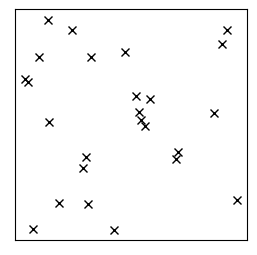

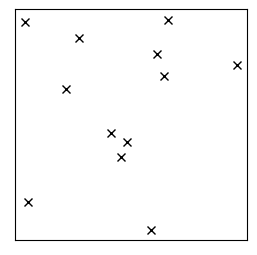

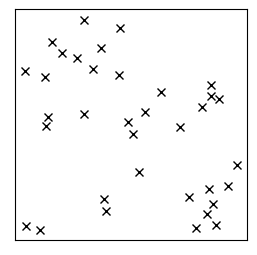

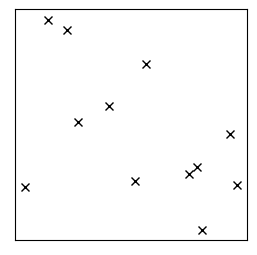

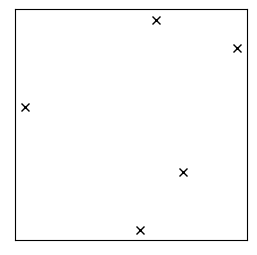

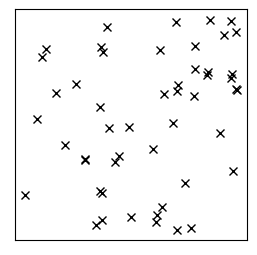

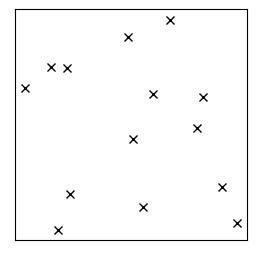

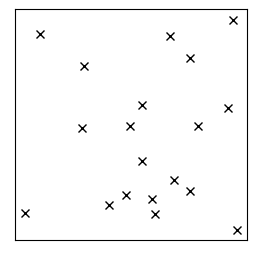

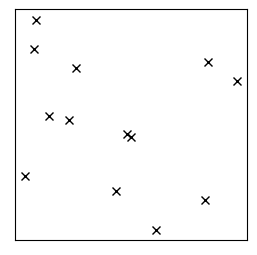

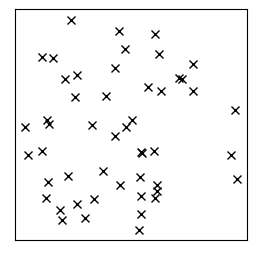

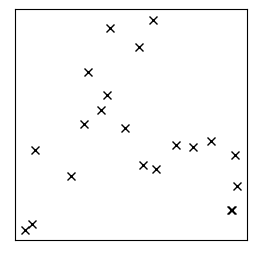

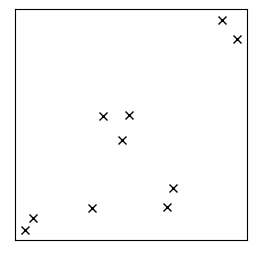

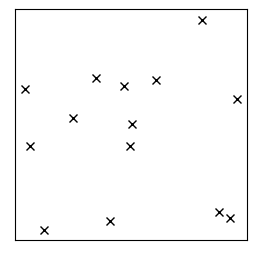

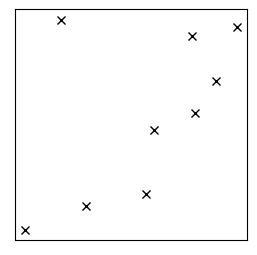

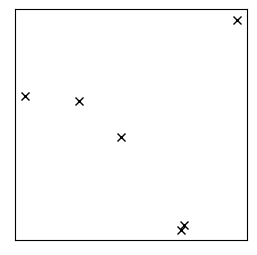

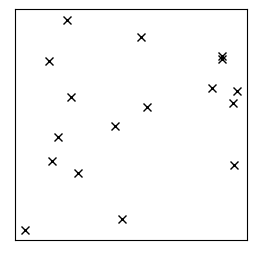

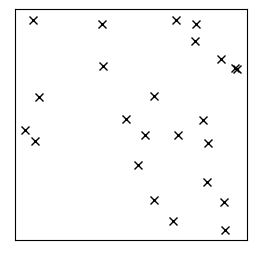

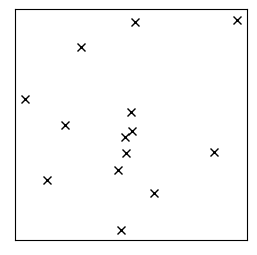

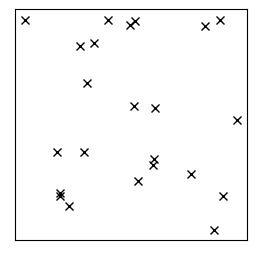

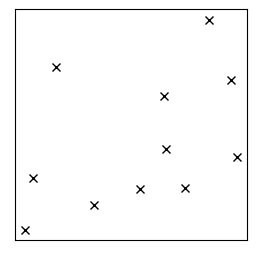

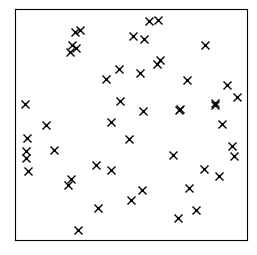

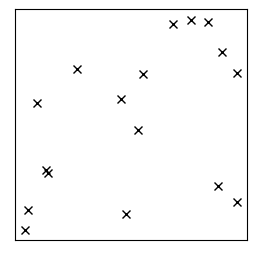

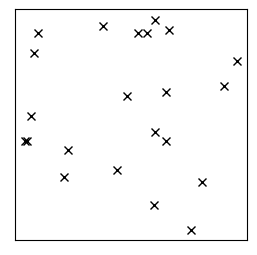

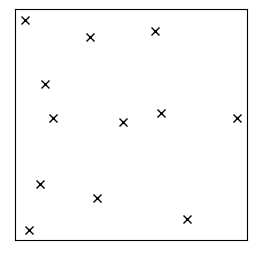

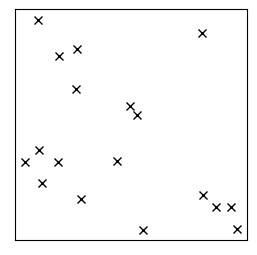

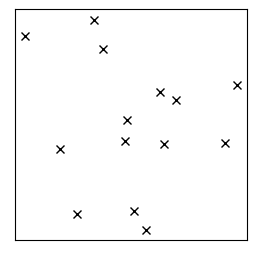

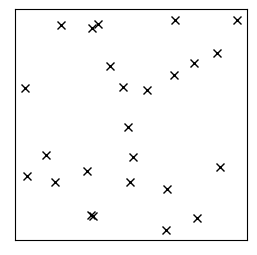

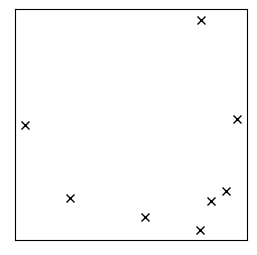

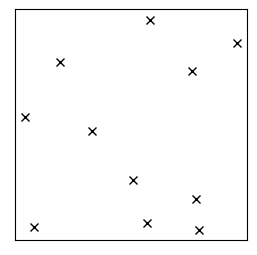

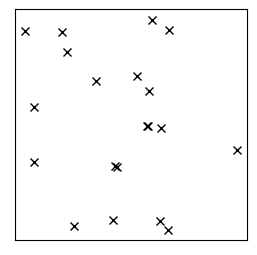

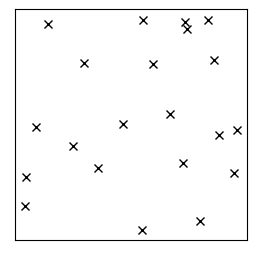

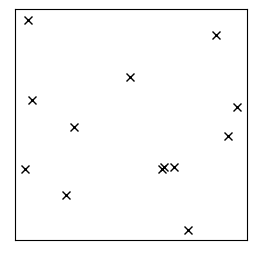

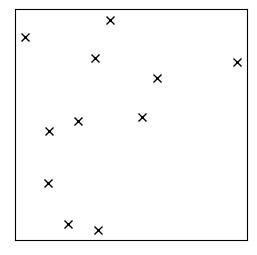

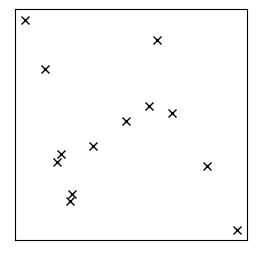

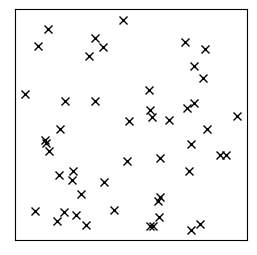

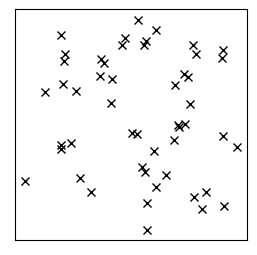

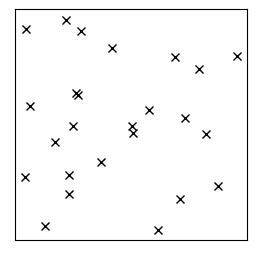

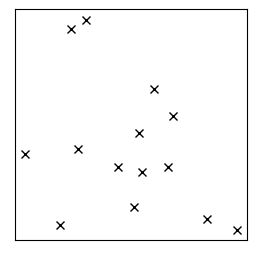

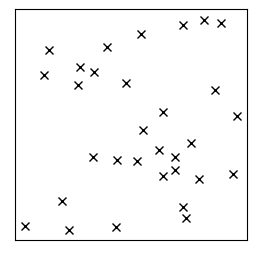

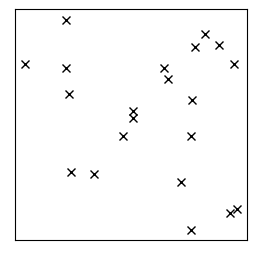

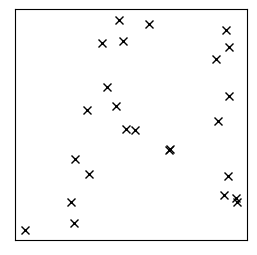

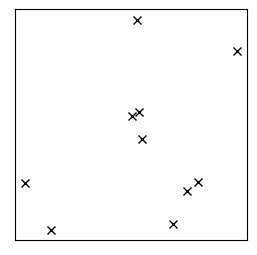

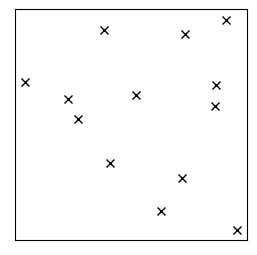

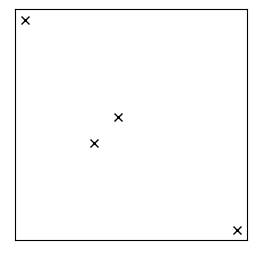

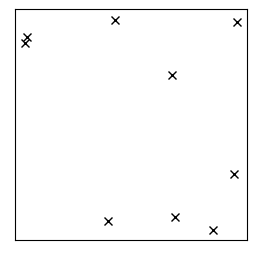

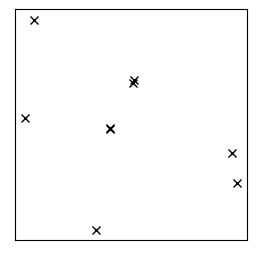

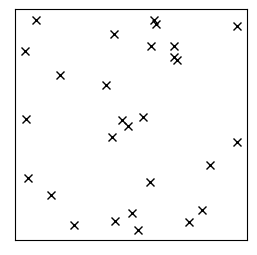

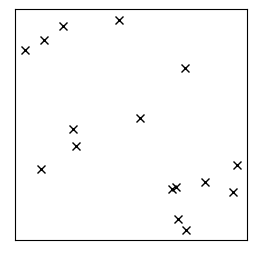

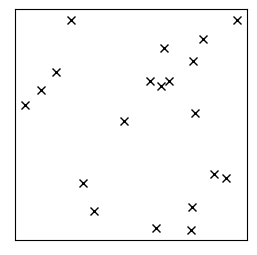

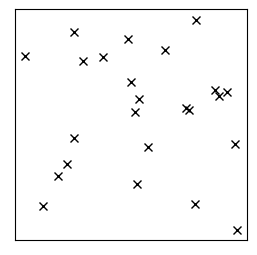

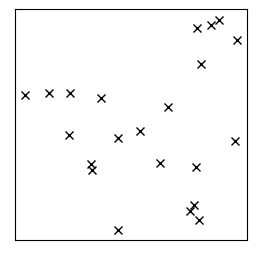

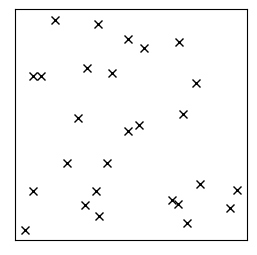

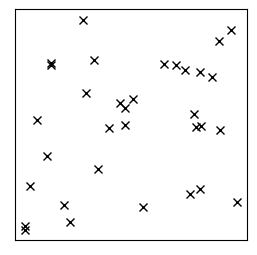

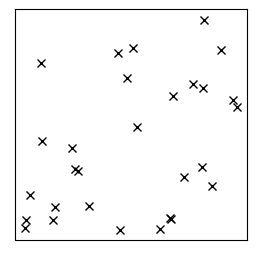

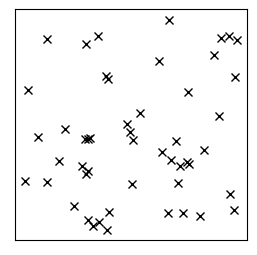

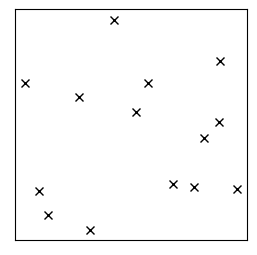

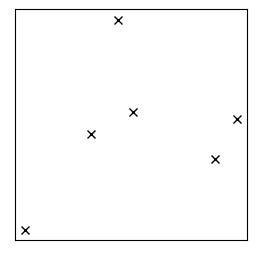

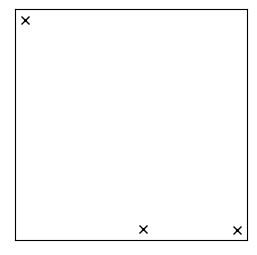

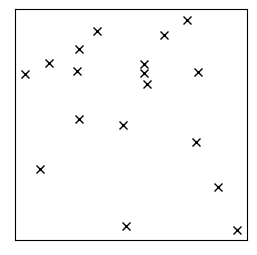

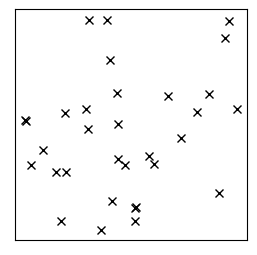

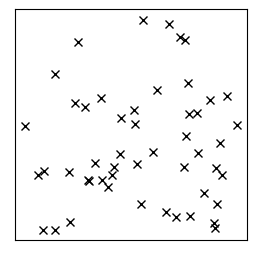

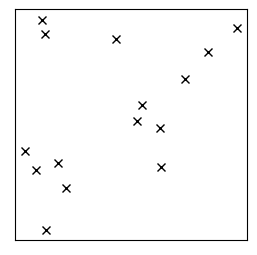

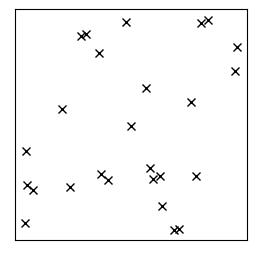

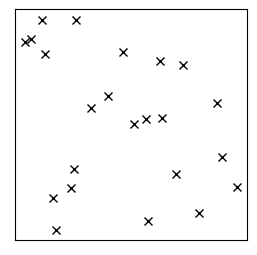

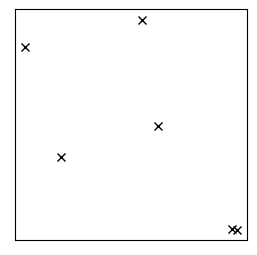

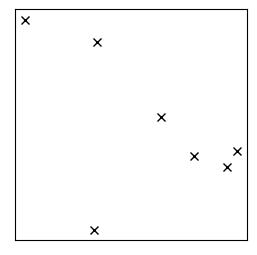

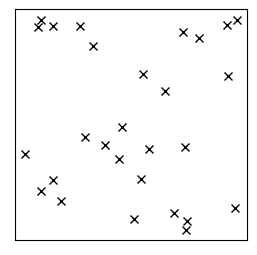

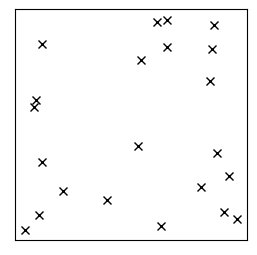

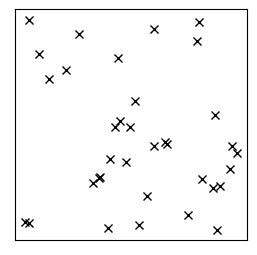

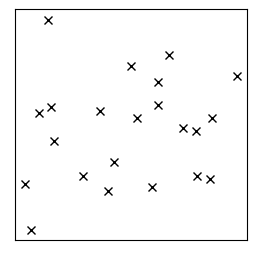

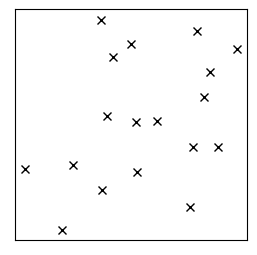

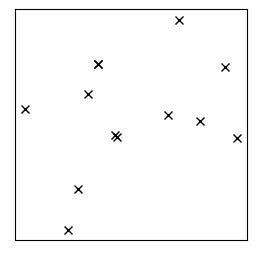

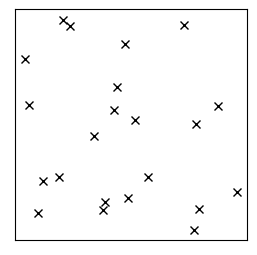

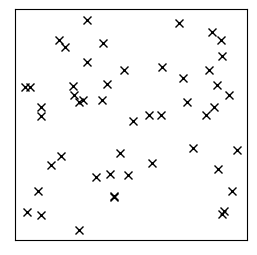

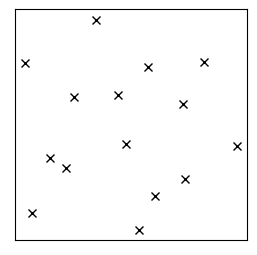

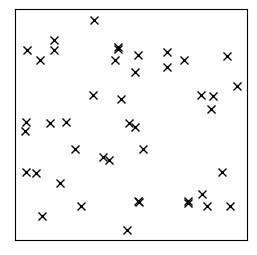

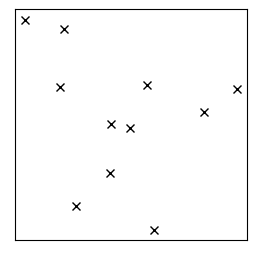

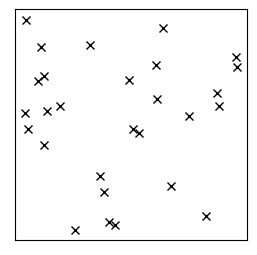

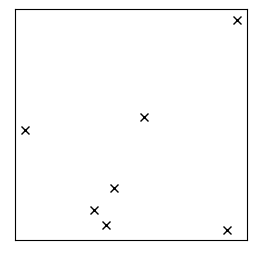

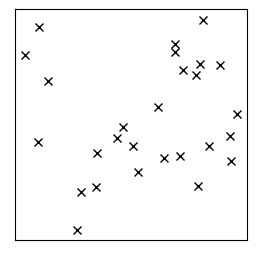

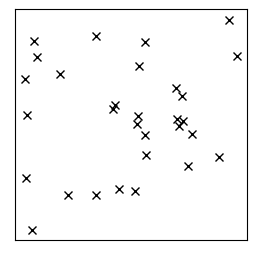

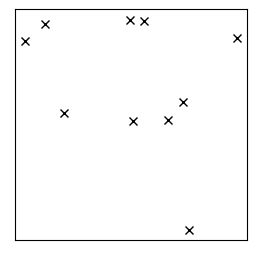

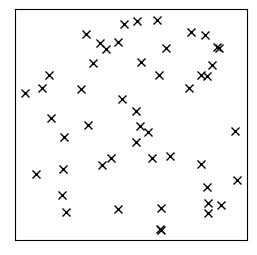

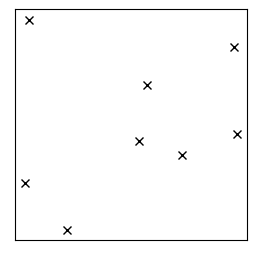

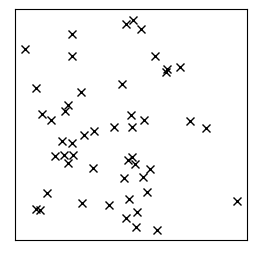

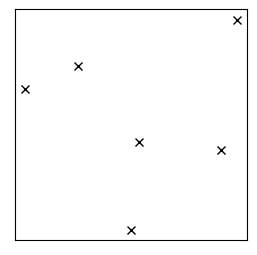

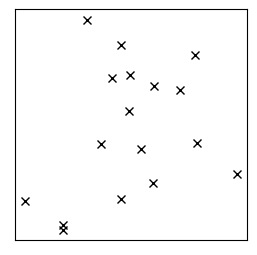

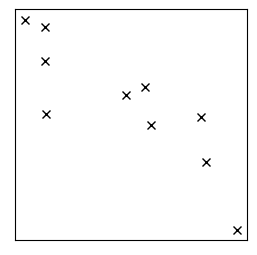

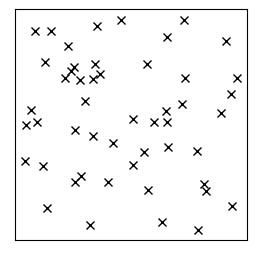

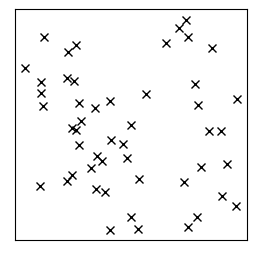

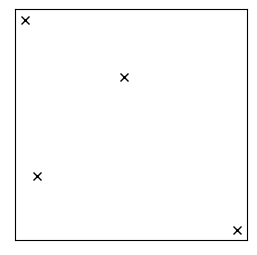

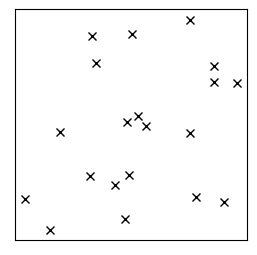

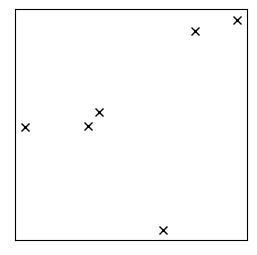

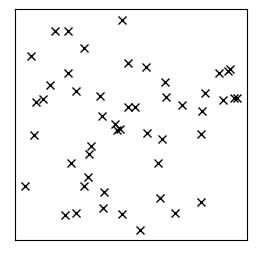

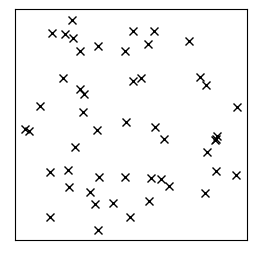

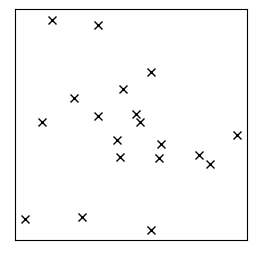

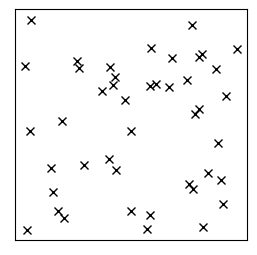

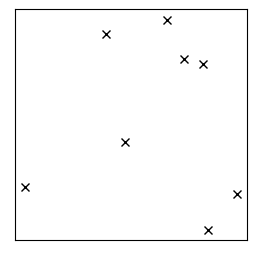

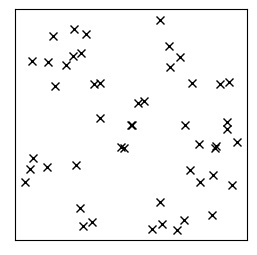

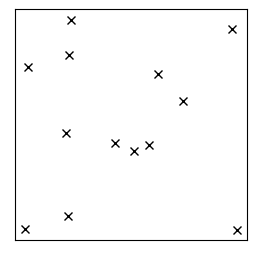

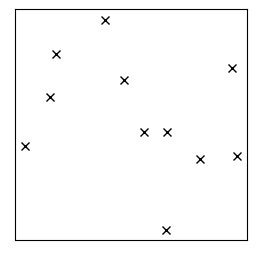

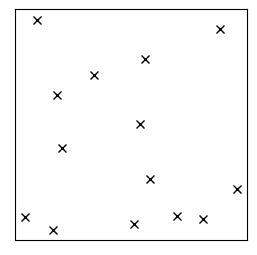

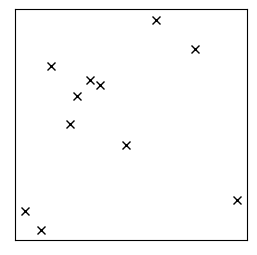

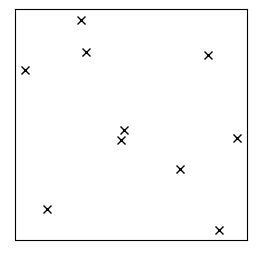

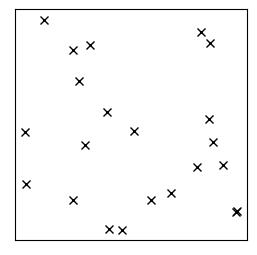

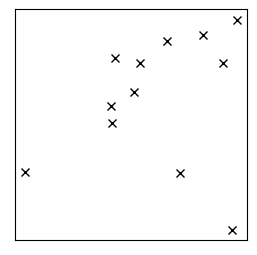

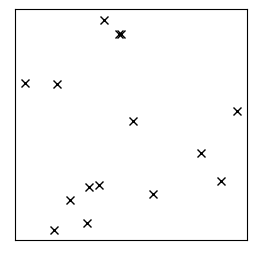

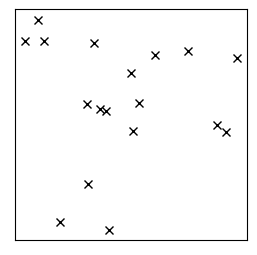

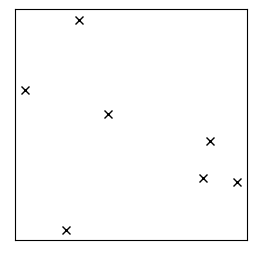

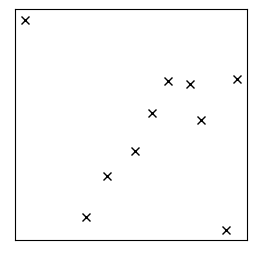

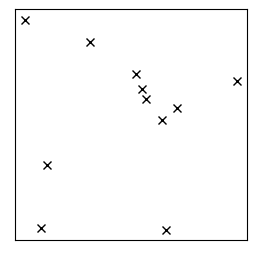

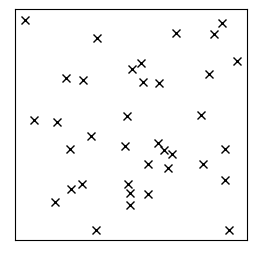

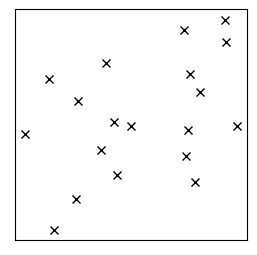

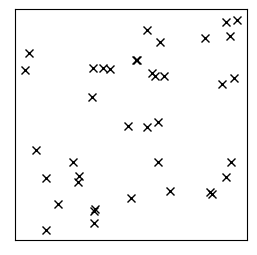

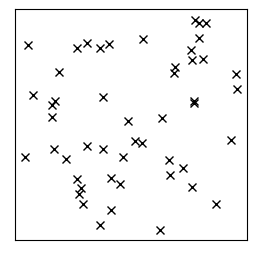

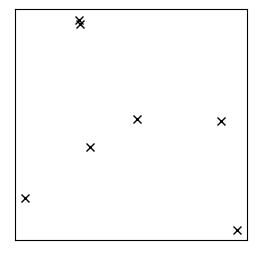

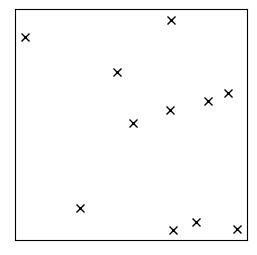

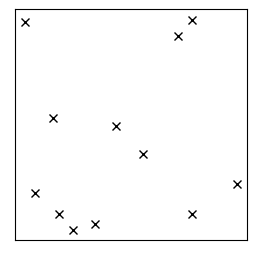

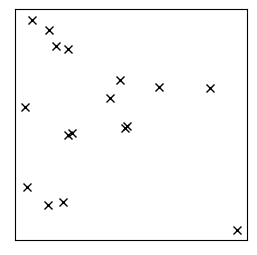

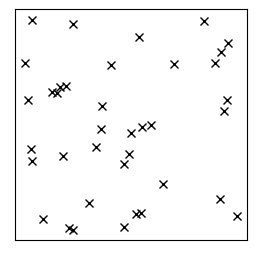

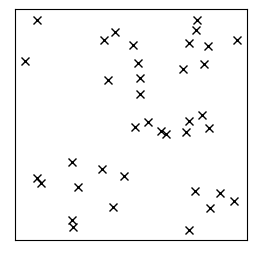

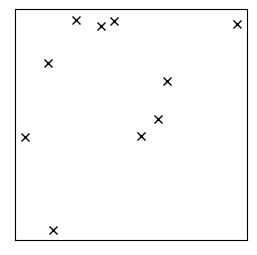

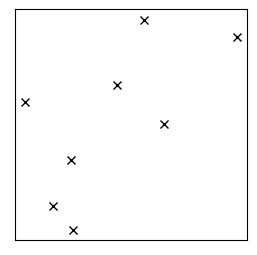

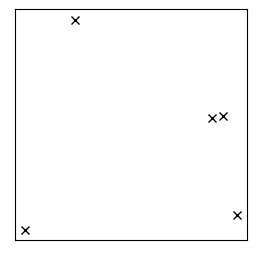

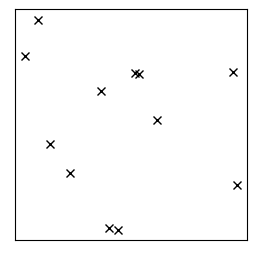

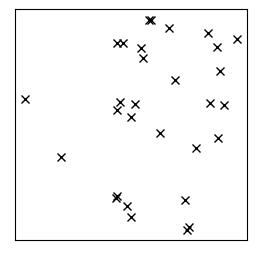

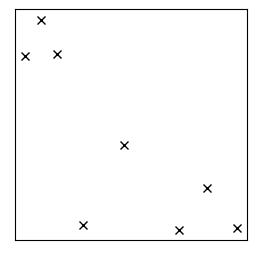

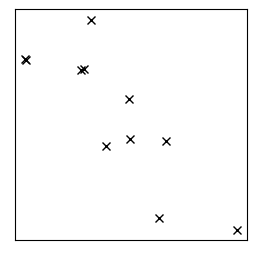

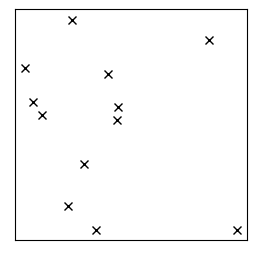

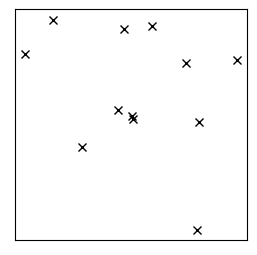

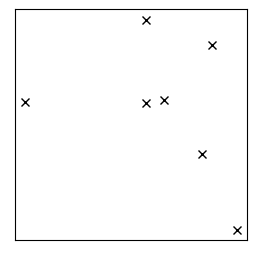

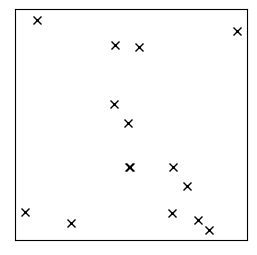

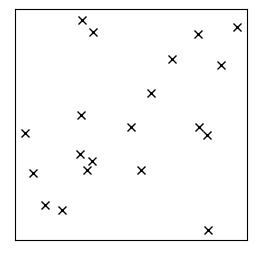

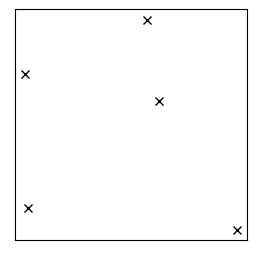

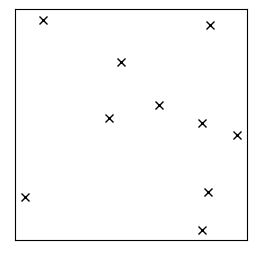

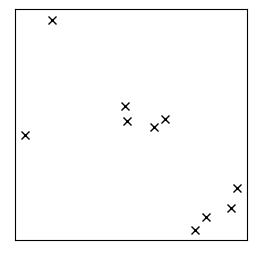

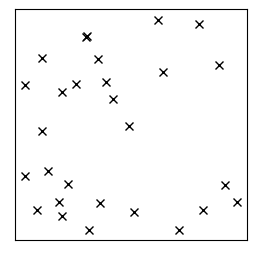

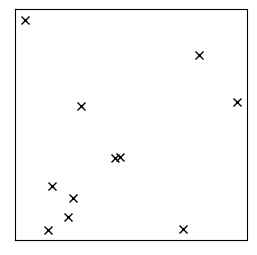

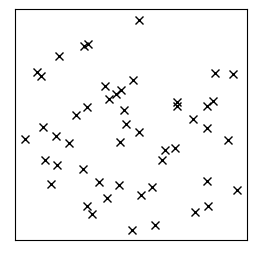

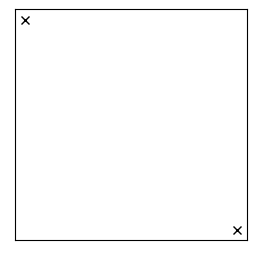

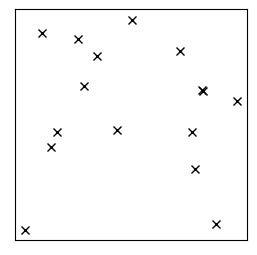

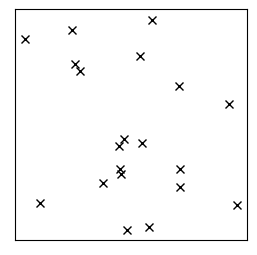

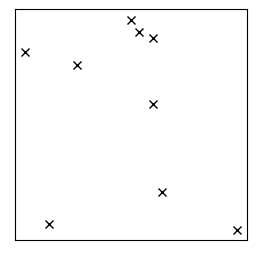

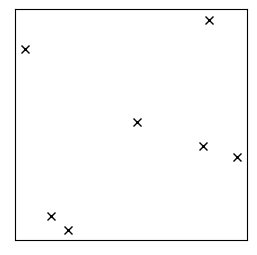

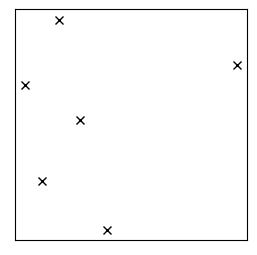

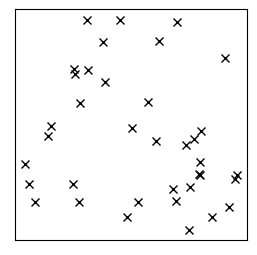

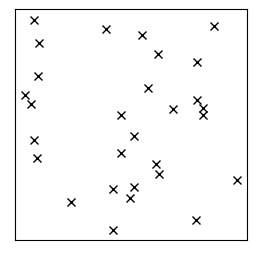

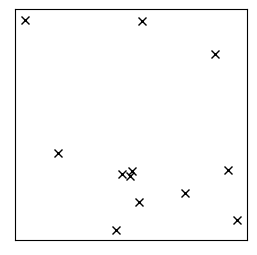

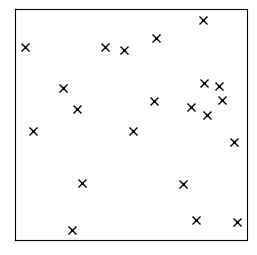

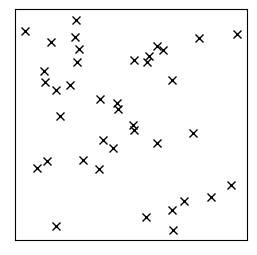

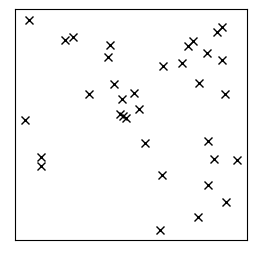

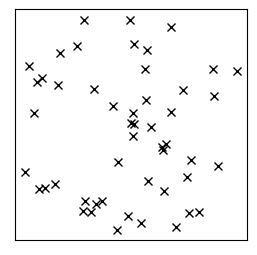

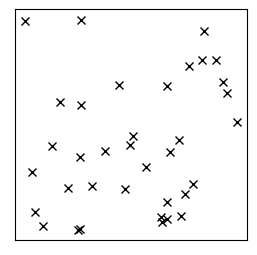

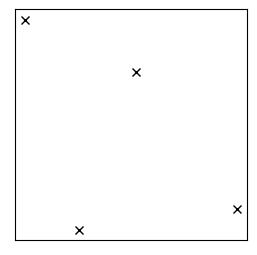

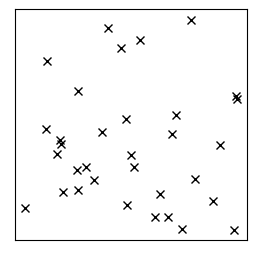

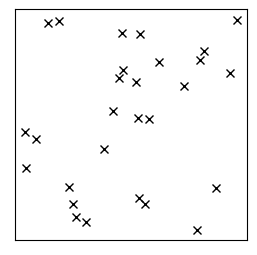

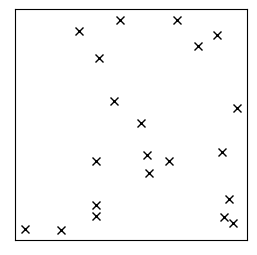

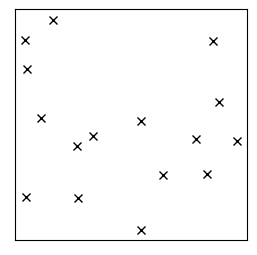

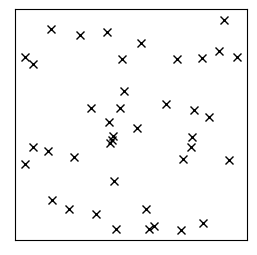

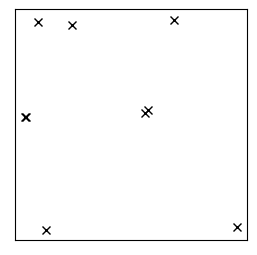

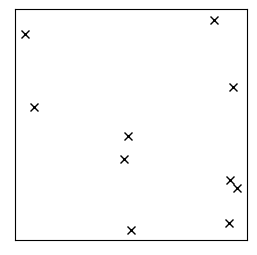

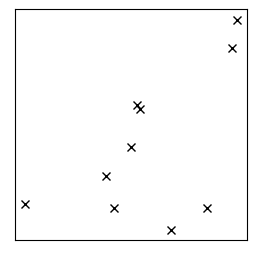

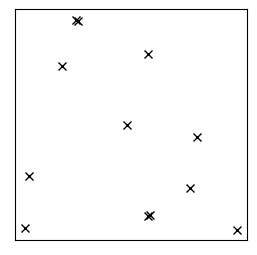

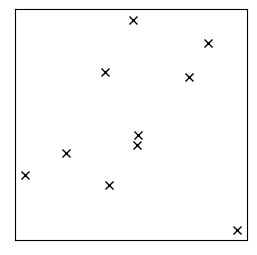

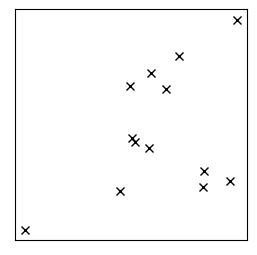

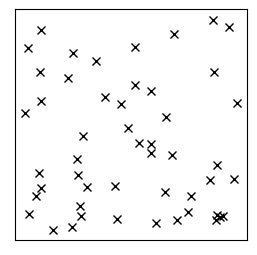

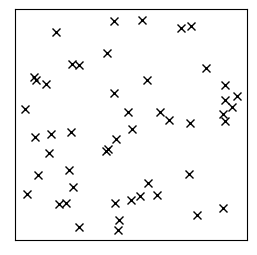

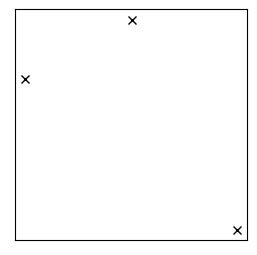

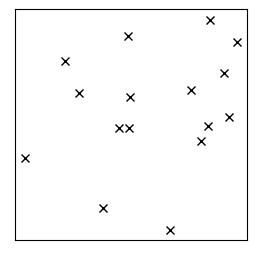

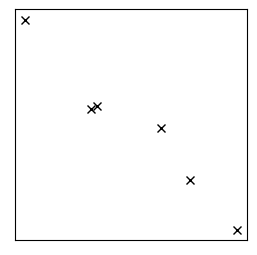

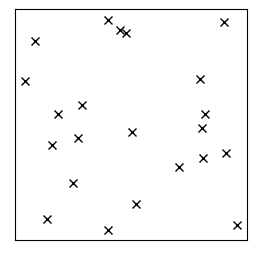

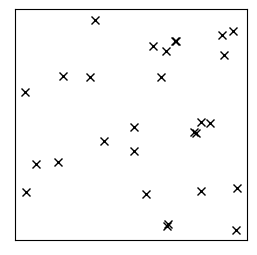

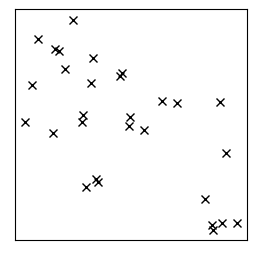

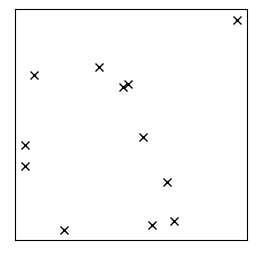

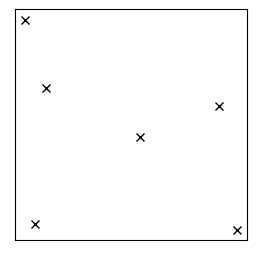

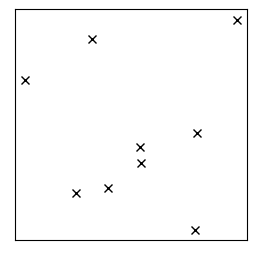

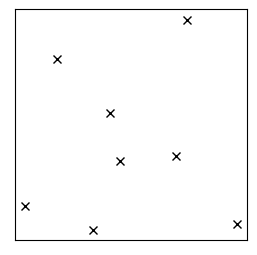

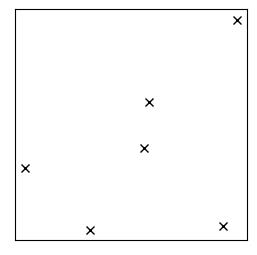

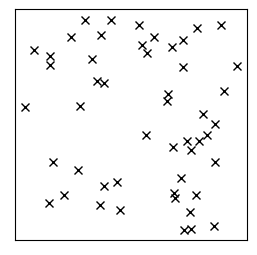

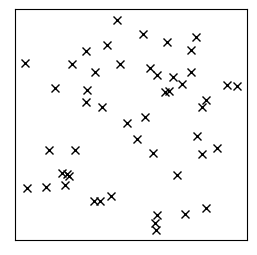

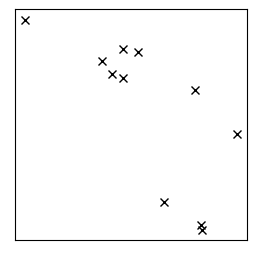

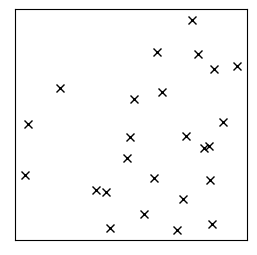

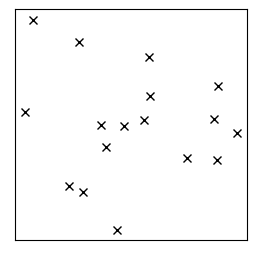

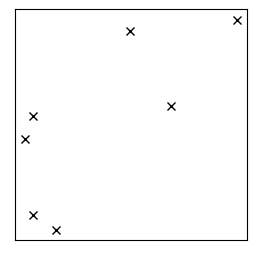

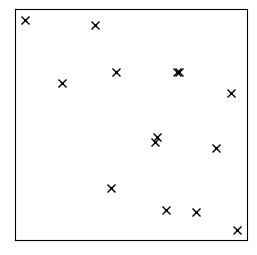

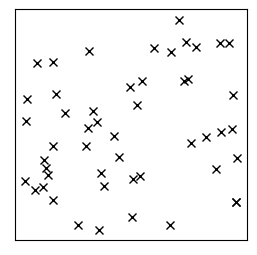

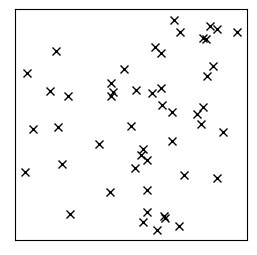

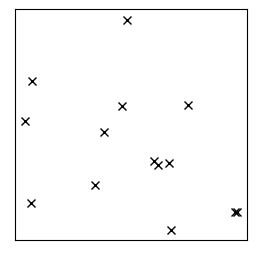

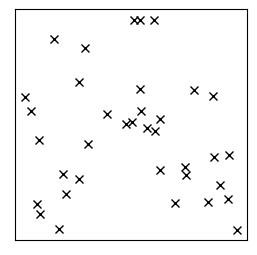

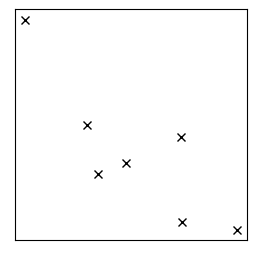

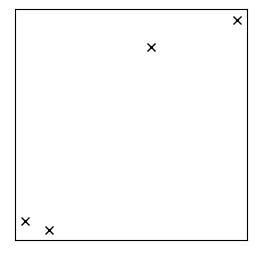

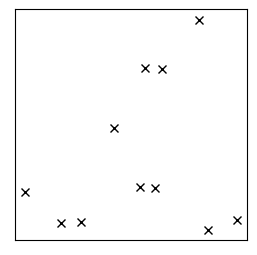

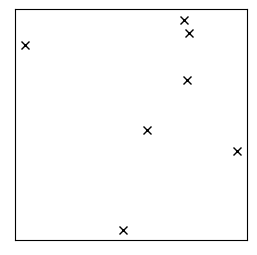

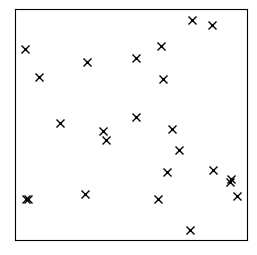

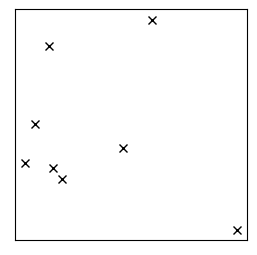

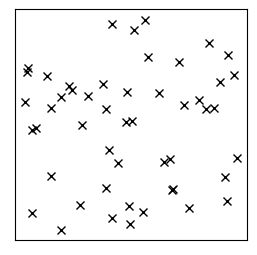

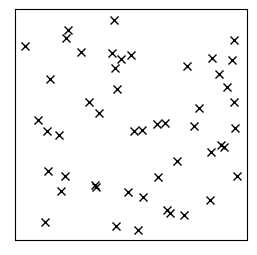

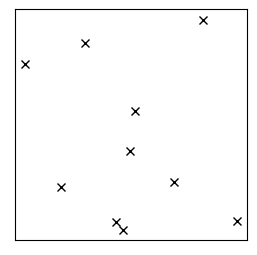

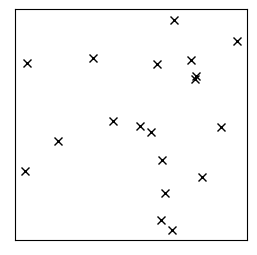

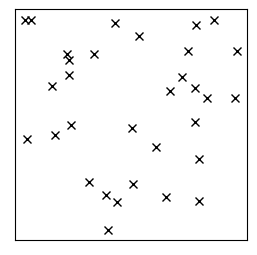

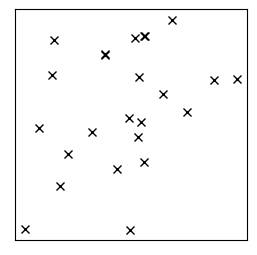

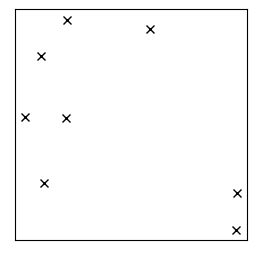

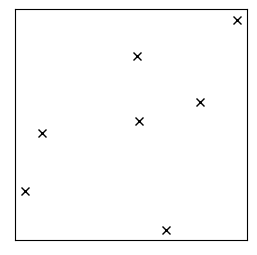

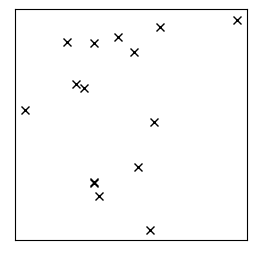

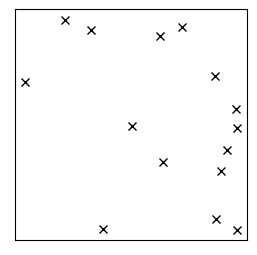

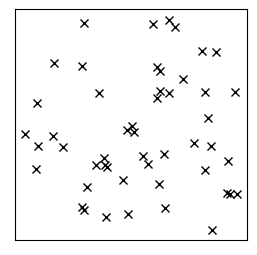

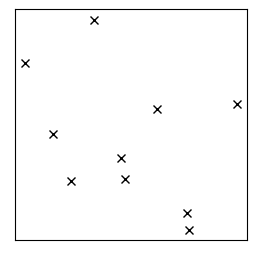

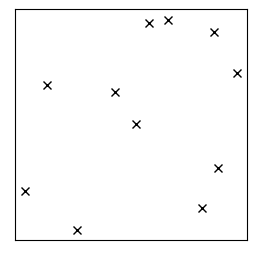

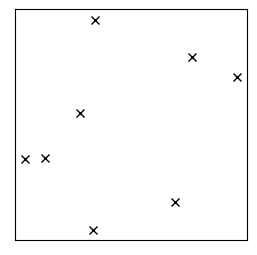

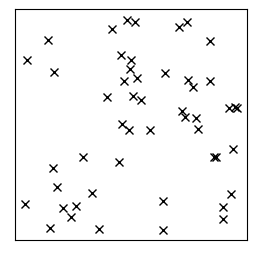

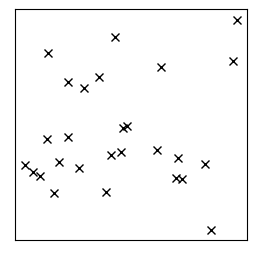

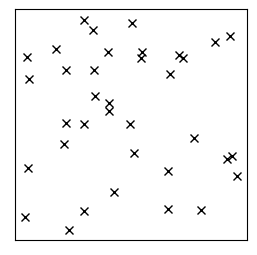

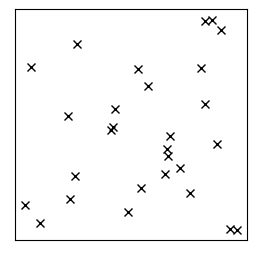

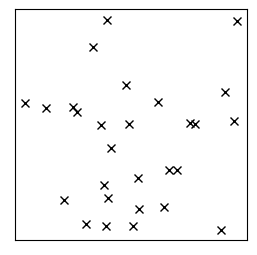

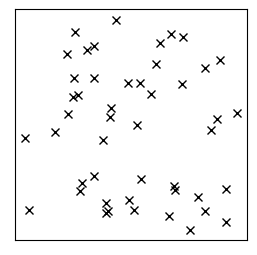

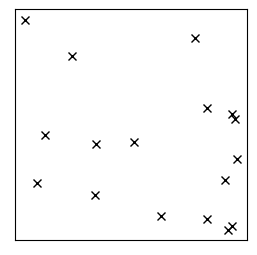

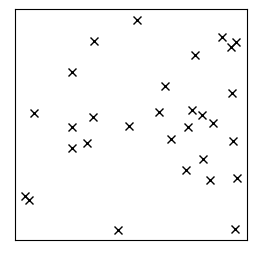

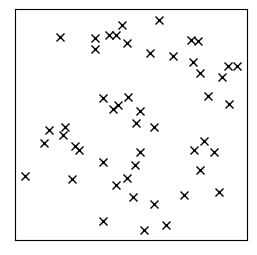

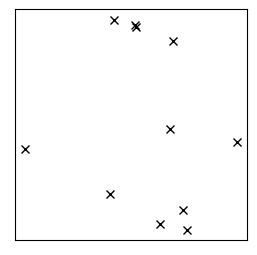

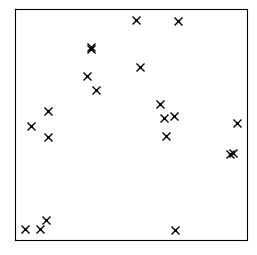

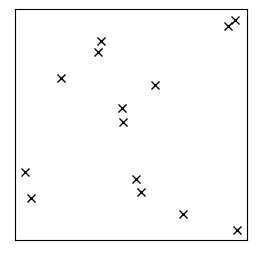

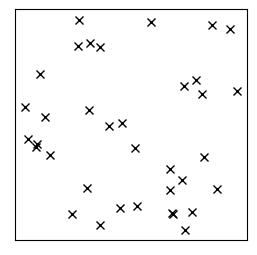

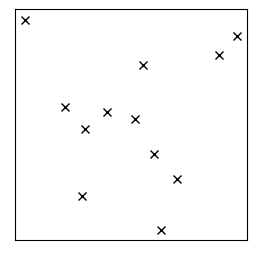

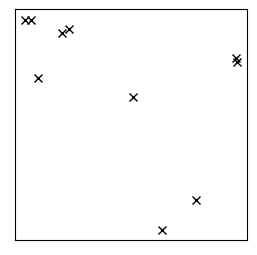

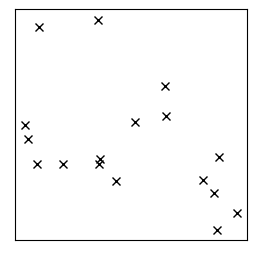

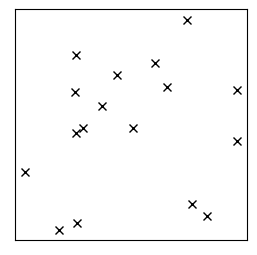

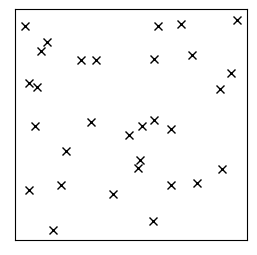

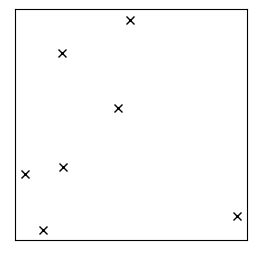

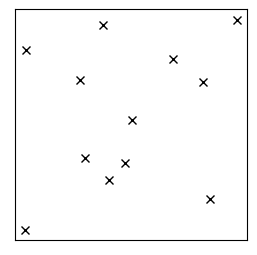

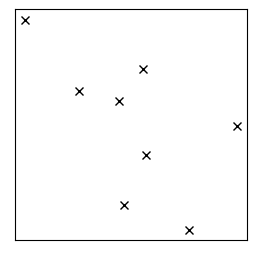

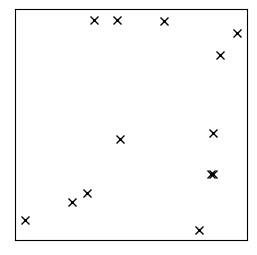

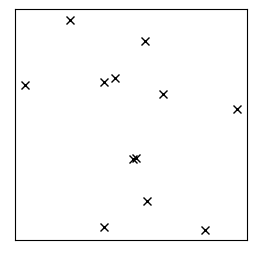

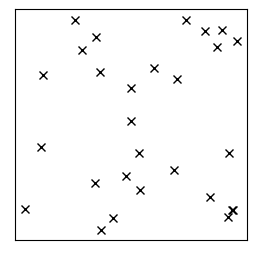

In [34]:
for i in range(len(rs)):
    plt.figure(figsize=(3,3))
    plt.xticks([]);plt.yticks([]);
    
    ra_gaia,dec_gaia = np.array(rs[i]['ra']),np.array(rs[i]['dec'])
    plt.plot(ra_gaia,dec_gaia,'kx')
    
    ix_finite = np.where(np.isfinite(ra_gaia) & np.isfinite(dec_gaia))
    d = angularSeparation(RA[i],DEC[i],ra_gaia[ix_finite],dec_gaia[ix_finite])    
    try:
        ix_match = np.argmin(d)
    except ValueError:
        print(f"No matching Gaia source for {i}")
        raise


In [35]:
print('GAIA MATCH OFFSET')
gaia_match_dist = []
for i in range(len(RA)): 
    ix_match = np.argmin(rs[i][np.where(d*60*60 < 3)]['parallax_over_error'])
    ix = ix_finite[0][ix_match]
    gaia_match_offset=angularSeparation(RA[i],DEC[i],rs[i][ix]['ra'],rs[i][ix]['dec'])*60*60
    gaia_match_dist.append(gaia_match_offset[0])
    print(f"{gaia_match_offset[0]} as")  

GAIA MATCH OFFSET
0.5926791977605707 as
1.1442319477106622 as
0.03909968536724294 as
0.19802174920840665 as
0.8478770972498241 as
0.8098797869089231 as
1.9250806251017274 as
1.5908848591925264 as
0.4794199551081652 as
0.39751815896177234 as
0.671512553843481 as
1.6312408983146782 as
0.15500401431584096 as
0.5608811519956252 as
0.8677919596004022 as
11.2042066586135 as
3.0601368603186376 as
0.20183468393329876 as
0.6643960724766047 as
6.56024695093869 as
0.01815679194417109 as
1.5209784756924911 as
5.330306061602881 as
0.18115164351682445 as
0.3250891608692477 as
5.176240592187573 as
0.6090286050058141 as
0.9286519682460648 as
0.11980491177205392 as
0.3116356507063658 as
1.3071821607882022 as
1.1603020973025897 as
0.4262412535113237 as
0.19209648892987144 as
2.37025229395401 as
0.04401018170058013 as
0.03448199885120305 as
1.7951966493345042 as
3.590697967075277 as
1.0894472464413514 as
0.9076337943534838 as
0.10102789187890829 as
0.2718667603516314 as
0.5372229804991063 as
0.5668735639

In [36]:
d_pc = []
print('GAIA ID & DISTANCES')
for i in range(len(rs)):
    gaia_dr3_source_id=rs[i][ix]['source_id']
    par,par_err = rs[i][ix]['parallax'],rs[i][ix]['parallax_error']
    gaia_distance=1000/par
    d_pc.append(gaia_distance)
    print(gaia_dr3_source_id,'@',f'{gaia_distance} parsecs')
    

GAIA ID & DISTANCES
2882017544897587456 @ 212.9437068379279 parsecs
2738626591386423424 @ 66.52028268588535 parsecs
531375179226880256 @ 1106.187032007378 parsecs
2765454164004531328 @ 619.2184950791286 parsecs
2765458012295273344 @ 352.2410709682985 parsecs
393993847040070272 @ 99.34279123345337 parsecs
2849997227971447040 @ 80.78780379784072 parsecs
2874319284171715968 @ 100.61938652171298 parsecs
2772757154594946560 @ 391.48528876829204 parsecs
422688489185463680 @ 109.04312959718462 parsecs
2860951829821782016 @ 72.07212056441469 parsecs
2848630088340967040 @ 36.84457445706962 parsecs
2798013314642147968 @ 97.2886546879917 parsecs
2798709374221931264 @ 150.3637463925778 parsecs
2753405887385092352 @ 111.8038668926711 parsecs
2768048564768256512 @ 12.166368167174484 parsecs
383275940831929728 @ 37.214188708983805 parsecs
2850360616563900800 @ 423.1974118699687 parsecs
2876561050940272256 @ 86.80830802662813 parsecs
2856874535763703680 @ 18.84602043888753 parsecs
428965463632676736 @

In [37]:
gpoe=[]
for i in range(len(rs)):
    gaia_parallax_over_err = rs[i][ix]['parallax_over_error']
    gpoe.append(gaia_parallax_over_err)
#gpoe

skypos

### TARGET TABLE

In [40]:
target_table = pd.DataFrame({
                    'ID': IDs,
                    'RA': RA,
                    'DEC':DEC,
                    'Distance (pc)': d_pc,
                    'Simbad Match Offset': simbad_match_dist,
                    'Gaia Match Offset': gaia_match_dist,
                    'Gaia Parallax-Over-Error': gpoe,
                    'Spectral Type': sp_type
    })


In [42]:
#target_table.to_csv('target_table_v4.csv')
target_table

,ID,RA,DEC,Distance (pc),Simbad Match Offset,Gaia Match Offset,Gaia Parallax-Over-Error,Spectral Type
0,194140883,0.799390,40.874429,212.943707,0.003855,0.592679,253.721527,K4
1,257468888,0.178464,1.539418,66.520283,0.005839,1.144232,273.424255,K4/5V
2,378587653,0.787423,71.666174,1106.187032,0.003576,0.039100,41.050968,K1III
3,405266556,0.278040,11.010090,619.218495,0.005630,0.198022,45.852348,K0
4,405266970,0.671196,10.906756,352.241071,0.001907,0.847877,141.267365,K3
...,...,...,...,...,...,...,...,...
228,371424444,43.098459,19.135403,390.349996,0.000859,0.234056,117.641434,M6.5V
229,387514723,43.212127,8.610317,169.36059,0.003044,0.195548,186.938675,K1III
230,436884337,43.060654,28.625115,194.132522,0.001506,0.881475,29.910681,K5
231,91482401,44.798077,21.978623,162.56246,0.001510,0.432161,58.794544,M4


In [43]:
path = '/Users/katborski/Documents/GitHub/QPPs/moonbow-main/fast_lc_files/'

In [44]:
# open data & create list of datafiles
event_files = []
for visit in os.listdir(path):
    vis_path = path+visit
    event_files+=[vis_path]


In [82]:
def match_id_to_spectraltype(filename,target_table):
    
    """ Matches distances in target table to TICID in event files"""
    
    with fits.open(filename, mode="readonly",ignore_missing_simple=True) as hdulist:
        ticid = hdulist[0].header['TICID']
    
    loc = target_table.loc[target_table['ID']==ticid]
    ix = loc.index
    st = target_table['Spectral Type'][ix].values
    
    return st

In [79]:
def match_id_to_distance(filename,target_table):
    
    """ Matches distances in target table to TICID in event files"""
    
    with fits.open(filename, mode="readonly",ignore_missing_simple=True) as hdulist:
        ticid = hdulist[0].header['TICID']
    
    loc = target_table.loc[target_table['ID']==ticid]
    ix = loc.index
    dist = target_table['Distance (pc)'][ix].values
    
    return dist, ticid

In [83]:
ticids = []
sky_pos = []
dists = []
ontimes = []
n_flares=[]
max_energies = []
max_energy_errors = []
min_energies = []
min_energy_errors = []
sp_ty = []


for i in range(len(event_files)):
    # 9,19,27 & 31 produce different indexing errors
    # 14,15 & 30 produce empty/corrupt fits file errors
    flare_data = []
    try:

        flaring_frame, ontime, skypos = dataClean(event_files[i])
        q_frame = generate_Qcurve(flaring_frame)
        
        dist, ticid = match_id_to_distance(event_files[i],target_table)
        st = match_id_to_spectraltype(event_files[i],target_table)
        
        
        ranges,flux = find_flare_ranges(flaring_frame,q_frame,3,quiescence=None) 
        flare_ranges = refine_flare_ranges(flaring_frame,q_frame,3)
            ### flare_ranges contains 2 elements: 
            ###    [0] = flare_ranges,
            ###    [1] = flare_flux
        
        flare_total_energies = energyCalculation2(flaring_frame,q_frame,flare_ranges,dist,binsize=20)
            ### flare_total_energies has 2 elements: 
            ###     [0] = integrated energy
            ###     [1] = integrated energy error
        
        n_flares_i = len(flare_ranges[0])
        n_flares.append(n_flares_i)
        
        ticids.append(ticid)
        sky_pos.append(skypos)
        dists.append(dist)
        ontimes.append(ontime)
        sp_ty.append(st)
        
        max_flare_energy = max(flare_total_energies[0])
        max_energies.append(max_flare_energy)
            
        max_flare_energy_error = max(flare_total_energies[1])
        max_energy_errors.append(max_flare_energy_error)
            
        min_flare_energy = min(flare_total_energies[0])
        min_energies.append(min_flare_energy)
            
        min_flare_energy_error = min(flare_total_energies[1])
        min_energy_errors.append(min_flare_energy_error)
        print(i)
    except: 
        print(str('fail'),i)
            ### compute basic stats


    #flare_total_energies = energycalculation2(flaring_frame,q_frame,flare_ranges,binsize=20)
    #qpp_data = qpp_find(flaring_frame,flare_ranges[0],flare_ranges[1])
        ### qpp_data contains 5 elements: 
        ###    [0] = large_flare_data,
        ###    [1] = large_flare_time,
        ###    [2] = large_flare_det, 
        ###    [3] = large_flare_params, 
        ###    [4] = large_flare_fits
    #residuals, res_fits = fit_residuals(qpp_data[0],qpp_data[4])
    #flare_table = FlareTable(flaring_frame,flare_ranges,flare_total_energies)
#print(len(ranges))

0
1
2
3
fail 4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
fail 41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
fail 120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
fail 142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
fail 158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
fail 186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
fail 203
204
205
206
207
208
209
fail 210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
fail 256
257
258
259
260
261
262
263
264
265
2

In [89]:
### Build Table 

flare_stat_table = pd.DataFrame({
                        'TIC': ticids,
                        'Position': sky_pos,
                        'Distance (pc)': dists,
                        'Spectral Type': sp_ty,
                        'Time on Source (days)': ontimes,
                        'Number of Flares': n_flares,
                        'Max Flare Energy (ergs)': max_energies,
                        'Max Flare Energy Error': max_energy_errors,
                        'Min Flare Energy (ergs)': min_energies,
                        'Min Flare Energy Error': min_energy_errors
})

    

In [91]:
#flare_stat_table.to_csv('flare_stat_table_v2.csv')
flare_stat_table

,TIC,Position,Distance (pc),Spectral Type,Time on Source (days),Number of Flares,Max Flare Energy (ergs),Max Flare Energy Error,Min Flare Energy (ergs),Min Flare Energy Error
0,266012752,"(12.7542496385771, 8.33633067709839)",[271.1577320305259],[K1V(e)],24.960567,560,[3.664488281718746e+34],[4.1233287778818565e+33],[3.199698455981281e+33],[2.3788250788537498e+33]
1,293458637,"(27.029884455089, 1.50867768371774)",[588.159683000924],[M5.5Ve],26.342948,1124,[4.263578645921744e+35],[1.8686603785196283e+34],[1.3171660197712093e+34],[9.64611310136428e+33]
2,288296589,"(5.44771863412458, 38.4573174051584)",[75.54974488721608],[K4/5(III)],28.473467,128,[1.2459495445460516e+32],[3.7696792275129208e+31],[3.489136117056669e+31],[2.51771273609871e+31]
3,26765575,"(25.1065898707156, 26.9591709074573)",[94.53329358725811],[K4:],28.473986,235,[2.7952904071500174e+32],[8.791250114733146e+31],[6.392264596087648e+31],[4.713278415343693e+31]
4,53709089,"(17.7367370801548, 61.0921083082539)",[-3537.585639198313],[K0III],27.442787,724,[3.2150994985418325e+36],[5.601173558892835e+35],[3.690778379958395e+35],[2.719633273486407e+35]
...,...,...,...,...,...,...,...,...,...,...
301,137263695,"(31.443173952428, 73.4049187144411)",[126.87525387760158],[K5],24.197799,150,[7.640563634531317e+32],[1.7943839349512513e+32],[1.0547369742292285e+32],[7.436558176151733e+31]
302,22844983,"(39.0622862088136, 25.5385663396836)",[928.3390099720923],[K3/4V],24.011887,1459,[6.3256969046820545e+35],[6.377665158758532e+34],[3.7519768194626662e+34],[2.7824146293689014e+34]
303,150972929,"(5.50995513930772, 20.7025457905632)",[832.5978784872156],[K1Vk:],28.473063,1003,[5.452141743015847e+35],[6.1955132138185e+34],[2.931551541386266e+34],[2.1750252860220627e+34]
304,354842480,"(39.0704028937401, 67.5129329400808)",[69.98668681687161],[K4/5V],26.159613,799,[4.1139471070449763e+33],[4.6090936678904e+32],[3.5958178321774445e+32],[2.656785983135242e+32]


In [75]:
len(ontimes)

318

In [76]:
ontimes

[24.960567464628674,
 26.3429483843341,
 28.47346665206385,
 28.473985879784646,
 25.21742752925432,
 27.44278662315682,
 24.340583218293617,
 28.472989082569452,
 24.476692876991137,
 26.159694252924236,
 27.44272524130643,
 27.44305523352344,
 24.734140278924514,
 24.012052248759602,
 24.379140311804136,
 27.442535132659792,
 28.473889876483202,
 28.473741907351844,
 27.920286261424913,
 24.40884833583695,
 27.442956374759046,
 24.47691695154018,
 27.44269001455624,
 28.473880526386395,
 24.393635517690832,
 26.159734862826006,
 28.473194699413337,
 27.442834701795324,
 27.44284775329866,
 28.473912083539375,
 24.197851291792663,
 27.442546293582957,
 28.47374269474783,
 27.443121088963192,
 24.734348278932067,
 24.476980273298242,
 27.442546257624596,
 24.33080267199863,
 27.442974481178638,
 24.33394775676105,
 24.951209455361308,
 24.403721660529218,
 25.217331741818317,
 28.47391223981996,
 24.47679129273004,
 24.909852768174943,
 27.442487644568278,
 24.408207091987574,
 27.4428

In [ ]:
this = fits.open('/Users/katborski/Documents/GitHub/QPPs/moonbow-main/fast_lc_files/tess2020266004630-s0030-0000000293458637-0195-a_fast-lc.fits')

In [81]:
skypos

(28.2057186228075, 49.6066347653372)